In [44]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from einops.einops import rearrange, repeat

In [181]:
def process_phantom_data(folder=r'data/DigitalPhantomCT'):
    print("Reading Dicom directory:", folder)
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_data = sitk.GetArrayFromImage(image)
    # values: AIF/VOF, Exp R(t) for CBV 1-5, Lin R(t) for CBV 1-5, Box R(t) for CBV 1-5,
    image_data = rearrange(image_data, '(t values) h w -> values t h w', t=30)

    aif_location = (123,251,8) # start, start, size
    aif_data = image_data[0,:,
               aif_location[0]:aif_location[0]+aif_location[2],
               aif_location[1]:aif_location[1]+aif_location[2]]
    aif_data = np.mean(aif_data, axis=(1,2))

    vof_location = (410,247,16) # start, start, size
    vof_data = image_data[0,:,
               vof_location[0]:vof_location[0]+vof_location[2],
               vof_location[1]:vof_location[1]+vof_location[2]]
    vof_data = np.mean(vof_data, axis=(1,2))

    simulated_data_size = 32 * 7
    scan_center = image_data.shape[-1]//2
    simulated_data_start = scan_center - simulated_data_size//2
    simulated_data_end = scan_center + simulated_data_size//2

    perfusion_data = image_data[1:,:,
                     simulated_data_start:simulated_data_end,
                     simulated_data_start:simulated_data_end]
    # exp_data data has shape 5 (CBV) x 30 (Time) x 224 (7 x delay_step) x 224 (7 x MTT step)
    [exp_data, lin_data, box_data] = np.array_split(perfusion_data, 3, axis=0)


    perfusion_values = np.empty([exp_data.shape[0], 7, 7, 4])
    cbv = [1, 2, 3, 4, 5] # in ml / 100g
    mtt_s = [24.0, 12.0, 8.0, 6.0, 4.8, 4.0, 3.42857143] # in seconds
    mtt_m = [t/60 for t in mtt_s] # in minutes
    delay = [0., 0.5, 1., 1.5, 2., 2.5, 3.] # in seconds

    for ix, i in enumerate(cbv):
        for jx, j in enumerate(delay):
            for kx, k in enumerate(mtt_m):
                # 0:'cbv', 1:'delay', 2:'mtt_m', 3:'cbf'
                values = np.array([i, j, k, i/k])
                perfusion_values[ix, jx, kx] = values
    perfusion_values = repeat(perfusion_values, 'cbv h w values -> cbv (h r1) (w r2) values', r1=32, r2=32)

    return {'aif': aif_data,
            'vof': vof_data,
            'exp_curves': exp_data,
            'lin_curves': lin_data,
            'box_curves': box_data,
            'perfusion_values': perfusion_values}

In [182]:
data_dict = process_phantom_data()

Reading Dicom directory: data/DigitalPhantomCT


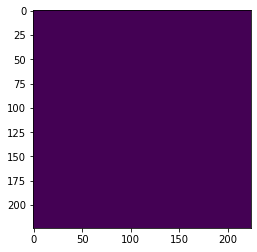

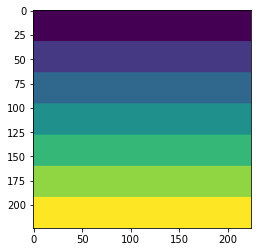

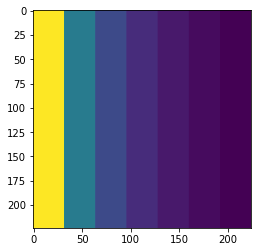

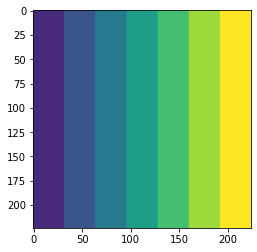

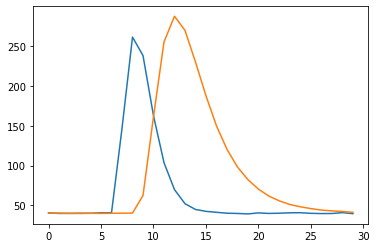

In [183]:
plt.imshow(data_dict['perfusion_values'][0,:,:,0], vmin=1, vmax=5)
plt.show()
plt.imshow(data_dict['perfusion_values'][0,:,:,1], vmin=0, vmax=3.)
plt.show()
plt.imshow(data_dict['perfusion_values'][0,:,:,2], vmin=3.4/60, vmax=24.0/60)
plt.show()
plt.imshow(data_dict['perfusion_values'][4,:,:,3], vmin=2.5, vmax=87.5)
plt.show()


plt.plot(data_dict['aif'])
plt.plot(data_dict['vof'])
# curves = np.array_split(data_dict['box_curves'][0,:32,], 7, axis=2)
# plt.plot(np.mean(data_dict['box_curves'][0,:32,]))
plt.show()

In [185]:
set(data_dict['perfusion_values'][4,:,:,3][0])

{12.5, 25.0, 37.5, 50.0, 62.5, 75.0, 87.49999996354167}

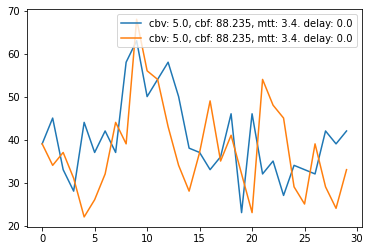

In [154]:
def plot_curves(data, gt, cbv, i_delay, i_mtt):
    i_delay = [i_delay] if not type(i_delay) == list else i_delay
    i_mtt = [i_mtt] if not type(i_mtt) == list else i_mtt
    assert(isinstance(i_delay, list) & isinstance(i_mtt, list) & isinstance(cbv, int))
    for i, j in zip(i_delay, i_mtt):
        plt.plot(data[cbv, :, i, j], label='cbv: {}, cbf: {}, mtt: {}. delay: {}'.format(
            np.round(gt[cbv,i,j,0],3),
            np.round(gt[cbv,i,j,3],3),
            np.round(gt[cbv,i,j,2]*60,3),
            np.round(gt[cbv,i,j,1],3))
            )
    plt.legend()
    plt.show()

plot_curves(data_dict['box_curves'], data_dict['perfusion_values'], cbv=4, i_delay=[0, 0], i_mtt=[200, 201])
# cbv = 0
# i, j = 100, 100
# data_dict['box_curves'].shape

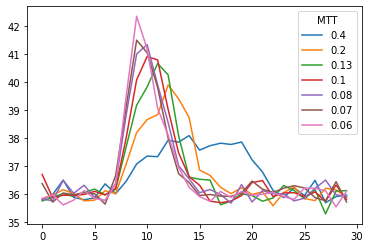

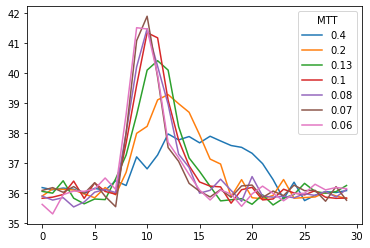

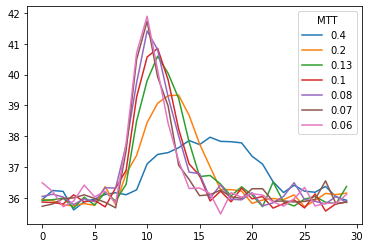

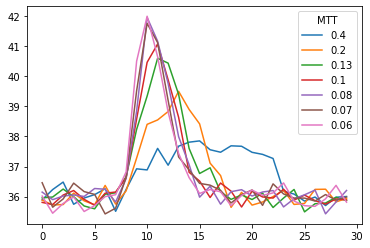

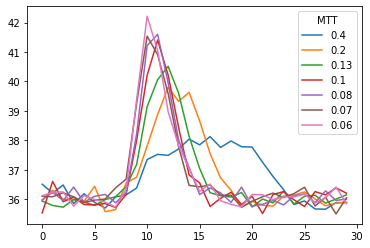

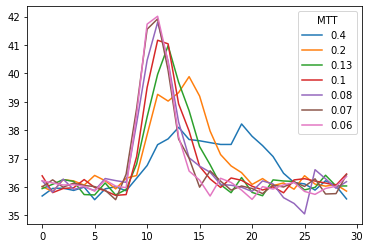

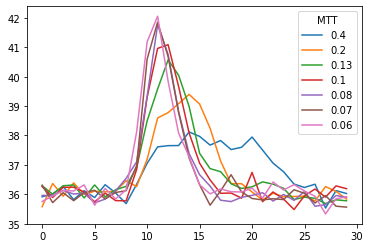

In [114]:
def plot_curve_mtts(data, delay=0):
    mtt_s = [24.0, 12.0, 8.0, 6.0, 4.8, 4.0, 3.4] # in seconds
    mtt_m = [t/60 for t in mtt_s]
    # split on delay time
    curves = np.array_split(data[0], 7, axis=1)
    # select curves with delay = 0 and split on MTT
    subcurves = np.array_split(curves[delay], 7, axis=2)
    # plot mean of each curves tile
    for ix, subcurve in enumerate(subcurves):
        plt.plot(np.mean(subcurve, axis=(1,2)), label=np.round(mtt_m[ix], 2))
    plt.legend(title='MTT')
    plt.show()
for i in range(0,7):

    plot_curve_mtts(data_dict['box_curves'], i)

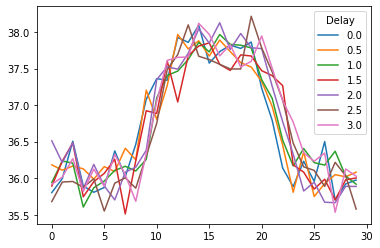

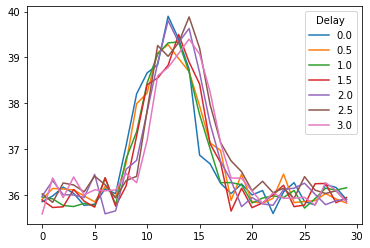

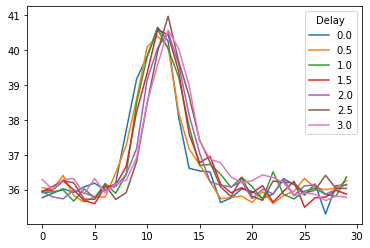

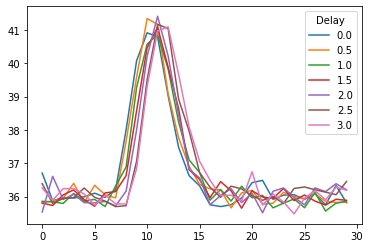

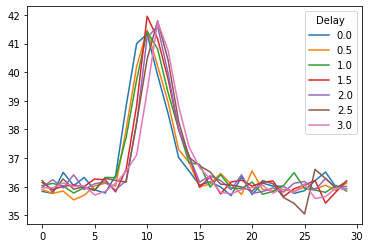

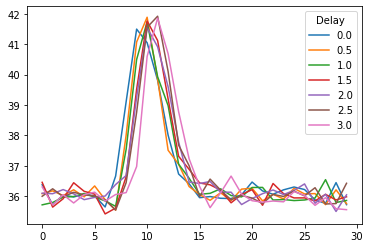

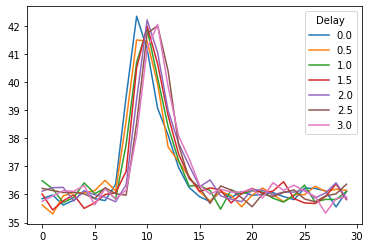

In [115]:
def plot_curve_delay(data, mtt=0):
    delay = [0., 0.5, 1., 1.5, 2., 2.5, 3.] # in seconds
    # split on delay time
    curves = np.array_split(data[0], 7, axis=1)

    for ix, curve in enumerate(curves):
        # split on MTT
        subcurves = np.array_split(curve, 7, axis=2)
        # select only with least MTT
        subcurves = subcurves[mtt]
        plt.plot(np.mean(subcurves, axis=(1,2)), label=np.round(delay[ix], 2))
    plt.legend(title='Delay')
    plt.show()
for i in range(0,7):
    plot_curve_delay(data_dict['box_curves'], i)